In [54]:
%matplotlib inline

If the `econml` and `wget` python packages are not installed on your machine install them by running the cells below.

In [55]:
!pip install econml

Importing all the necessary components

In [56]:
# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 回帰・統計
from statsmodels.api import OLS

# 機械学習
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer

# 因果推論
from econml.dml import LinearDML

import warnings

In [57]:
# Githubで提示するときに、警告をなくし見やすいように
warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=r".*does not have valid feature names.*")
warnings.filterwarnings("ignore", message=r".*Glyph.*missing from font.*")
warnings.filterwarnings("ignore", category=UserWarning, module=r".*sklearn\.calibration")

upload csv_file

In [58]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
!ls /content/drive/MyDrive/Econ_thesis

econ.ipynb	      テレビCM出稿データ_2025.csv    メインデータ_2025.csv
Web利用状況_2025.csv  テレビ番組別視聴状況_2025.csv  雑誌閲読状況_2025.csv


In [60]:
# 読み込みたいCSVが入っているフォルダのパス
folder_path = "/content/drive/MyDrive/Econ_thesis"

# フォルダ内のCSVファイル一覧を取得
csv_files = glob.glob(folder_path + '/*.csv')

dataframes_local = {}  # 辞書を初期化

# 各CSVファイルを読み込み
for path in csv_files:
    fn = path.split('/')[-1]               # ファイル名（例: sample.csv）
    df_name = fn.split('.')[0]              # 拡張子を除いた名前（辞書のキー用）

    try:
        dataframes_local[df_name] = pd.read_csv(path)
        print(f"CSVファイル '{fn}' をGoogle Driveから読み込みました。")
        display(dataframes_local[df_name].head())
    except Exception as e:
        print(f"CSVファイル '{fn}' の読み込み中にエラーが発生しました: {e}")

CSVファイル 'Web利用状況_2025.csv' をGoogle Driveから読み込みました。


,SampleID,PC_01_MA,PC_02_MA,PC_03_MA,PC_04_MA,PC_05_MA,PC_06_MA,PC_07_MA,PC_08_MA,PC_09_MA,...,CAT_INFO_15_05_MX,CAT_INFO_15_06_MX,CAT_INFO_15_07_MX,CAT_INFO_16_01_MX,CAT_INFO_16_02_MX,CAT_INFO_16_03_MX,CAT_INFO_16_04_MX,CAT_INFO_16_05_MX,CAT_INFO_16_06_MX,CAT_INFO_16_07_MX
0,1530001,1,0,0,0,1,1,1,0,0,...,0,0,1,1,1,0,0,0,0,0
1,1530002,1,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,1530003,1,1,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1530007,1,1,0,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,1530011,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


CSVファイル 'テレビCM出稿データ_2025.csv' をGoogle Driveから読み込みました。


,title_code_variable,title_code,column_ch,column_text,tv_day_text,title_name,rating_all,cm_code,item_name,company_name,broadcast_date,broadcast_start_time,cm_airtime
0,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1895275,番宣,番宣,2025/1/4,4:43:03,30
1,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1894372,番宣,番宣,2025/1/4,4:43:33,30
2,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1894383,番宣,番宣,2025/1/4,4:54:33,30
3,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1891982,番宣,番宣,2025/1/4,5:02:52,30
4,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1895272,番宣,番宣,2025/1/4,5:11:33,30


CSVファイル 'テレビ番組別視聴状況_2025.csv' をGoogle Driveから読み込みました。


,SampleID,TVWatch.12501010453,TVWatch.12501010454,TVWatch.12501010500,TVWatch.12501010510,TVWatch.12501010600,TVWatch.12501010610,TVWatch.12501010655,TVWatch.12501010657,TVWatch.12501010700,...,TVWatch.122503152230,TVWatch.122503152300,TVWatch.122503152330,TVWatch.122503152400,TVWatch.122503152425,TVWatch.122503152455,TVWatch.122503152525,TVWatch.122503152550,TVWatch.122503152615,TVWatch.122503152645
0,1530001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1530002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1530003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1530007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1530011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


CSVファイル 'メインデータ_2025.csv' をGoogle Driveから読み込みました。


,SampleID,SEX_CD,AGE,MARRIAGE,CHILD_CD,CHILD_CD2,CHILD_AGE_1,CHILD_AGE_2,CHILD_AGE_3,CHILD_AGE_4,...,PI_Scale_16_02_MX,PI_Scale_16_03_MX,PI_Scale_16_04_MX,PI_Scale_16_05_MX,PI_Scale_16_06_MX,PI_Scale_16_07_MX,PI_Scale_16_08_MX,PI_Scale_16_09_MX,PI_Scale_16_10_MX,PI_Scale_16_11_MX
0,1530001,1,43,1,2,5,,,,,...,1,1,0,0,0,0,0,0,0,0
1,1530002,1,52,2,1,2,17,13,,,...,0,1,1,0,0,0,0,0,0,0
2,1530003,1,52,1,2,5,,,,,...,0,0,0,0,0,0,0,0,0,1
3,1530007,1,54,2,2,5,,,,,...,0,0,0,0,0,0,0,0,0,1
4,1530011,1,57,2,1,1,16,,,,...,0,0,0,1,0,0,1,0,0,0


CSVファイル '雑誌閲読状況_2025.csv' をGoogle Driveから読み込みました。


,SampleID,MZ.2740390,MZ.2700404,MZ.0040488,MZ.1590383,MZ.2180464,MZ.2820489,MZ.2790489,MZ.2680448,MZ.0480441,...,MZ.1230243,MZ.2140494,MZ.2730492,MZ.2770487,MZ.2760488,MZ.2780490,MZ.2720488,MZ.2710488,MZ.2380244,MZ.0250268
0,1530001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1530002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1530003,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1530007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1530011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# データ特徴の閲覧

for df_name, df in dataframes_local.items():
    print(f'▼ {df_name} の情報 ---------------------')
    print(df.info())
    print(f'行数と列数: {df.shape}')  # (行数, 列数)
    print('\n')  # 区切り

for name, df in dataframes_local.items():
    print(f'▼ {name} の統計量（すべての型）---------------------')
    print(df.describe(include='all'))
    print('\n')


for name, df in dataframes_local.items():
    print(f'▼ {name} の欠損値数')
    print(df.isnull().sum())
    print('\n')

▼ Web利用状況_2025 の情報 ---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 525 entries, SampleID to CAT_INFO_16_07_MX
dtypes: int64(1), object(524)
memory usage: 10.0+ MB
None
行数と列数: (2500, 525)


▼ テレビCM出稿データ_2025 の情報 ---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317518 entries, 0 to 317517
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   title_code_variable   317518 non-null  object 
 1   title_code            317518 non-null  float64
 2   column_ch             317518 non-null  int64  
 3   column_text           317518 non-null  object 
 4   tv_day_text           317518 non-null  object 
 5   title_name            317518 non-null  object 
 6   rating_all            317518 non-null  float64
 7   cm_code               317518 non-null  int64  
 8   item_name             317518 non-null  object 
 9   company_name        

メインデータに対してのコード

In [62]:
# Access the dataframe from the dictionary
df_main = dataframes_local['メインデータ_2025']

# 2. 対象列を抽出（AAQ列からBHQ列まで）
target_columns = df_main.loc[:, "PI_01_B00000474":"PS_02_B00005657"]

# 対象列のデータ型を確認
print(target_columns.dtypes)

# 対象列を数値型に変換
target_columns = target_columns.apply(pd.to_numeric, errors='coerce')

# データ型を確認（すべてfloatなどになっているはず）
print(target_columns.dtypes)

#欠損値の有無を確認
print(target_columns.isnull().sum())


PI_01_B00000474    object
PS_01_B00000474    object
PI_02_B00000474    object
PS_02_B00000474    object
PI_01_B00000720    object
                    ...  
PS_02_B00005635    object
PI_01_B00005657    object
PS_01_B00005657    object
PI_02_B00005657    object
PS_02_B00005657    object
Length: 844, dtype: object
PI_01_B00000474    float64
PS_01_B00000474    float64
PI_02_B00000474    float64
PS_02_B00000474    float64
PI_01_B00000720    float64
                    ...   
PS_02_B00005635    float64
PI_01_B00005657    float64
PS_01_B00005657    float64
PI_02_B00005657    float64
PS_02_B00005657    float64
Length: 844, dtype: object
PI_01_B00000474    122
PS_01_B00000474    122
PI_02_B00000474     48
PS_02_B00000474     48
PI_01_B00000720    140
                  ... 
PS_02_B00005635    136
PI_01_B00005657     89
PS_01_B00005657     89
PI_02_B00005657    195
PS_02_B00005657    195
Length: 844, dtype: int64


In [63]:

# 各種統計量を計算
mean_values = target_columns.mean()
min_values = target_columns.min()
median_values = target_columns.median()
max_values = target_columns.max()

summary = pd.DataFrame({
    "mean": mean_values,
    "min": min_values,
    "median": median_values,
    "max": max_values
})

print(summary)



# 平均値が高い順に20個取り出す
highest_mean_20 = summary.sort_values(by="mean", ascending=False).head(20)

print(highest_mean_20)


                     mean  min  median  max
PI_01_B00000474  2.447855  1.0     2.0  4.0
PS_01_B00000474  3.490328  1.0     4.0  5.0
PI_02_B00000474  2.410277  1.0     2.0  4.0
PS_02_B00000474  3.398858  1.0     4.0  5.0
PI_01_B00000720  2.962712  1.0     3.0  4.0
...                   ...  ...     ...  ...
PS_02_B00005635  3.067259  1.0     3.0  4.0
PI_01_B00005657  3.185815  1.0     3.0  4.0
PS_01_B00005657  3.668602  1.0     4.0  4.0
PI_02_B00005657  3.047289  1.0     3.0  4.0
PS_02_B00005657  3.562690  1.0     4.0  4.0

[844 rows x 4 columns]
                     mean  min  median  max
PI_02_B00002802  5.806466  1.0     6.0  7.0
PI_01_B00002802  5.803412  1.0     6.0  7.0
PI_02_B00002803  5.799180  1.0     6.0  7.0
PI_02_B00002801  5.795537  1.0     6.0  7.0
PI_01_B00002801  5.787207  1.0     6.0  7.0
PI_01_B00002803  5.786354  1.0     6.0  7.0
PI_01_B00004567  5.120446  1.0     5.0  6.0
PI_02_B00004567  5.073149  1.0     5.0  6.0
PI_01_B00004568  5.072868  1.0     5.0  6.0
PI_02_B0

In [64]:
# 見たい指標（列名）のリスト
cols = [
    "PI_01_B00001262",
    "PS_01_B00001262",
    "PI_02_B00001262",
    "PS_02_B00001262"
]

# summaryから該当行を抜き出す
selected = summary.loc[cols]

print(selected)


                     mean  min  median  max
PI_01_B00001262  3.088248  1.0     3.0  5.0
PS_01_B00001262  4.861689  1.0     5.0  6.0
PI_02_B00001262  3.096299  1.0     3.0  5.0
PS_02_B00001262  4.901177  1.0     5.0  6.0


テレビ視聴状況CSVに対してのコード

テレビ視聴状況のdataframeから必要な列だけを取得して、新しいdataframeであるtvwatchを作成する

In [65]:
# Access the dataframe from the dictionary
df_sub1 = dataframes_local['テレビ番組別視聴状況_2025']
df_sub2 = dataframes_local['テレビCM出稿データ_2025']


# 「item_name」列に「Newヤクルト カロリーハーフ」を含む行を抽出し、「title_code_variable」列だけ取得
yakult_titlecodes = df_sub2.loc[
    df_sub2['item_name'].str.contains('Newヤクルト カロリーハーフ', na=False),
    'title_code_variable'
]

#seriesをリストに変換
yakult_titlecodes_list = yakult_titlecodes.tolist()


# df_sub1の最初の列名を取得
first_col = df_sub1.columns[0]

# 最初の列と yakult_titlecodes の列をまとめて選択
tv_watch = df_sub1[[first_col] + yakult_titlecodes_list]

# 各参加者の該当番組の視聴回数を合計
watch_sum = tv_watch[yakult_titlecodes_list].sum(axis=1)

# 合計列を追加
tv_watch['視聴番組数'] = watch_sum

# 確認
display(tv_watch.head())

# 参加者の該当番組の視聴数が０か1以上かでダミー変数を作り、列に追加
tv_watch.loc[tv_watch['視聴番組数'] >= 1, '視聴番組フラグ'] = 1
tv_watch.loc[tv_watch['視聴番組数'] < 1, '視聴番組フラグ'] = 0

# 確認
display(tv_watch[["SampleID", '視聴番組数', '視聴番組フラグ']].head())

# 追加したい列名リスト
add_cols = [
    "PI_01_B00001262",
    "PS_01_B00001262",
    "PI_02_B00001262",
    "PS_02_B00001262"
]

# df_mainから該当列だけ抜き出し
df_add = df_main[add_cols]

# tvwatchに横方向で追加
tv_watch = pd.concat([tv_watch, df_add], axis=1)

# 確認
display(tv_watch.head())


,SampleID,TVWatch.42501060700,TVWatch.42501060700,TVWatch.42501061355,TVWatch.42501061550,TVWatch.62501062200,TVWatch.82501060950,TVWatch.82501061545,TVWatch.82501061545,TVWatch.82501062300,...,TVWatch.102501311453,TVWatch.102501311550,TVWatch.102501312315,TVWatch.122501311113,TVWatch.102501312445,TVWatch.42502050700,TVWatch.42502120700,TVWatch.42502190700,TVWatch.42502260700,視聴番組数
0,1530001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1530002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,16
2,1530003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
3,1530007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
4,1530011,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,32


,SampleID,視聴番組数,視聴番組フラグ
0,1530001,0,0.0
1,1530002,16,1.0
2,1530003,13,1.0
3,1530007,15,1.0
4,1530011,32,1.0


,SampleID,TVWatch.42501060700,TVWatch.42501060700,TVWatch.42501061355,TVWatch.42501061550,TVWatch.62501062200,TVWatch.82501060950,TVWatch.82501061545,TVWatch.82501061545,TVWatch.82501062300,...,TVWatch.42502050700,TVWatch.42502120700,TVWatch.42502190700,TVWatch.42502260700,視聴番組数,視聴番組フラグ,PI_01_B00001262,PS_01_B00001262,PI_02_B00001262,PS_02_B00001262
0,1530001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,4,5,4,5
1,1530002,0,0,0,0,0,0,0,0,0,...,0,0,1,0,16,1.0,5,5,5,5
2,1530003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,1.0,5,5,5,6
3,1530007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,15,1.0,4,6,3,6
4,1530011,0,0,0,0,0,1,0,0,0,...,0,0,0,0,32,1.0,3,5,3,5


,SampleID,視聴番組数
0,1530001,0
1,1530002,16
2,1530003,13
3,1530007,15
4,1530011,32
...,...,...
2495,1534020,0
2496,1534022,0
2497,1534024,0
2498,1534027,12


視聴番組数
0      656
1      186
2      162
3      163
4      128
      ... 
69       1
80       1
88       1
91       1
216      1
Length: 64, dtype: int64


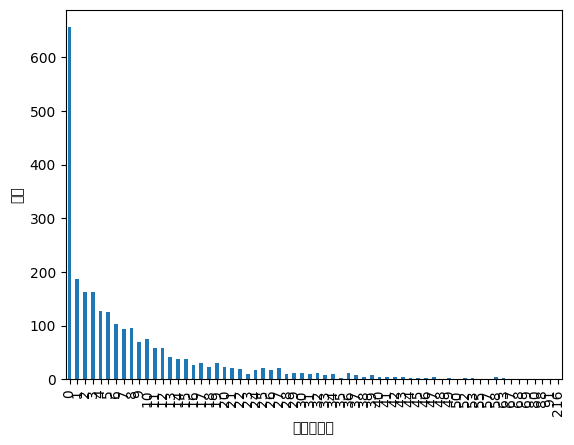

In [66]:
#IDと視聴合計数の表示
display(tv_watch[["SampleID", '視聴番組数']])


#視聴番組数別の人数を表示
counts = tv_watch.groupby('視聴番組数').size()
print(counts)
counts.plot(kind='bar')
plt.xlabel('視聴番組数')
plt.ylabel('人数')
plt.show()

### 購買意欲に対してのデータセット

In [67]:
#欲しいDataframeだけを抽出

# 抜き出したい列名をリストで指定
select_cols = ['SampleID', '視聴番組フラグ', 'PI_01_B00001262', 'PI_02_B00001262', "PS_02_B00001262"]

# 指定列だけ抜き出して新しいDataFrameを作成
tv_watch_selected = tv_watch[select_cols]

# 確認
display(tv_watch_selected.head())

,SampleID,視聴番組フラグ,PI_01_B00001262,PI_02_B00001262,PS_02_B00001262
0,1530001,0.0,4,4,5
1,1530002,1.0,5,5,5
2,1530003,1.0,5,5,6
3,1530007,1.0,4,3,6
4,1530011,1.0,3,3,5


## 共変量の作成

列ごとの欠損数:
NP_TAKUHAI_F_22_MX       2498
NP_TAKUHAI_F_20_MX       2498
NP_TAKUHAI_Page_20_MX    2498
NP_TAKUHAI_Page_22_MX    2498
NP_TAKUHAI_F_23_MX       2497
NP_TAKUHAI_F_19_MX       2497
NP_TAKUHAI_F_14_MX       2497
NP_TAKUHAI_Page_14_MX    2497
NP_TAKUHAI_Page_10_MX    2497
NP_TAKUHAI_F_10_MX       2497
NP_TAKUHAI_Page_23_MX    2497
NP_TAKUHAI_Page_19_MX    2497
NP_TAKUHAI_Page_11_MX    2496
NP_TAKUHAI_Page_15_MX    2496
NP_TAKUHAI_Page_25_MX    2496
NP_TAKUHAI_F_15_MX       2496
NP_TAKUHAI_F_11_MX       2496
NP_TAKUHAI_F_25_MX       2496
NP_TAKUHAI_F_16_MX       2495
NP_TAKUHAI_F_09_MX       2495
dtype: int64

列ごとの欠損率:
NP_TAKUHAI_F_22_MX       0.999
NP_TAKUHAI_F_20_MX       0.999
NP_TAKUHAI_Page_20_MX    0.999
NP_TAKUHAI_Page_22_MX    0.999
NP_TAKUHAI_F_23_MX       0.999
NP_TAKUHAI_F_19_MX       0.999
NP_TAKUHAI_F_14_MX       0.999
NP_TAKUHAI_Page_14_MX    0.999
NP_TAKUHAI_Page_10_MX    0.999
NP_TAKUHAI_F_10_MX       0.999
NP_TAKUHAI_Page_23_MX    0.999
NP_TAKUHAI_Page_19_MX    0.

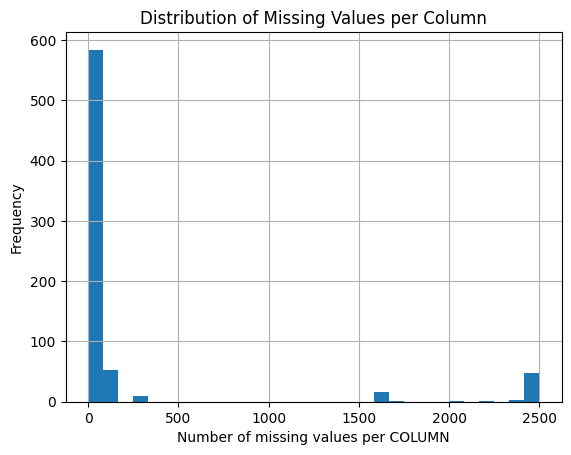

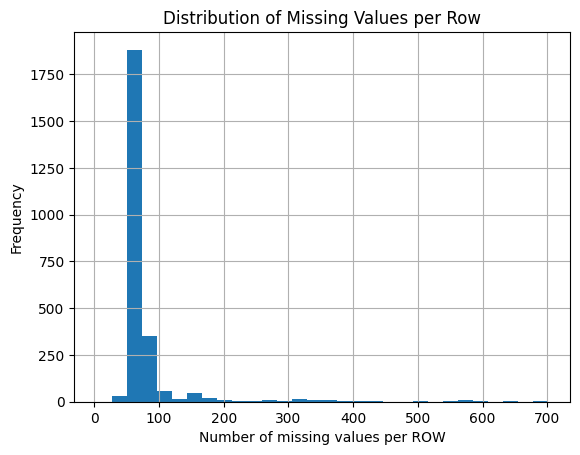

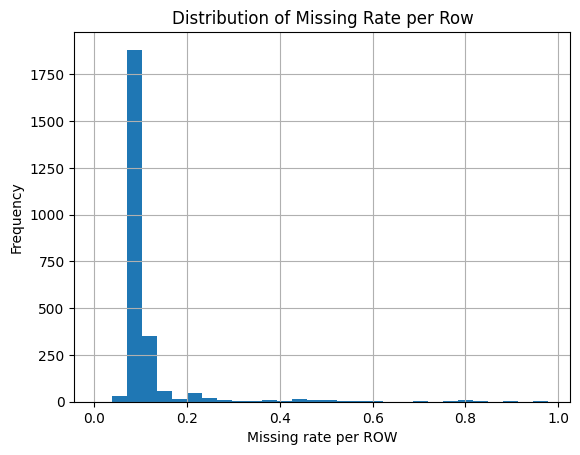

In [68]:
# 1) 列の切り出し（この範囲指定は列順に依存。想定どおりの列が入っているか要確認）
cov = df_main.loc[:, "SEX_CD":"PI_CAT_56"].copy()

# 2) 文字ベースの欠損を正規化：空白だけのセルは NaN に
#   - 空白（半角/全角/タブ/改行）だけ → NaN
cov = cov.replace(r'^\s*$', np.nan, regex=True)

#   - 文字列としての 'NaN'/'nan' だけ NaN に（実NaNはそのまま）
cov = cov.replace({'NaN': np.nan, 'nan': np.nan})


# 3) 列ごとの欠損「数」と「率」
col_missing_count = cov.isna().sum(axis=0)
col_missing_rate  = cov.isna().mean(axis=0)  # 0〜1

print("列ごとの欠損数:")
print(col_missing_count.sort_values(ascending=False).head(20))

print("\n列ごとの欠損率:")
print((col_missing_rate.sort_values(ascending=False).head(20)).round(3))

# 4) 行ごとの欠損「数」と「率」
row_missing_count = cov.isna().sum(axis=1)
row_missing_rate  = cov.isna().mean(axis=1)  # 0〜1

# 5) 可視化
# 列ごとの欠損数ヒスト
plt.figure()
col_missing_count.hist(bins=30)
plt.xlabel("Number of missing values per COLUMN")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Values per Column")
plt.show()

# 行ごとの欠損数ヒスト
plt.figure()
row_missing_count.hist(bins=30)
plt.xlabel("Number of missing values per ROW")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Values per Row")
plt.show()

# 行ごとの欠損率ヒスト
plt.figure()
row_missing_rate.hist(bins=30)
plt.xlabel("Missing rate per ROW")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Rate per Row")
plt.show()


列ごとの欠損数:
CHILD_AGE_5    2493
CHILD_AGE_4    2487
CHILD_AGE_3    2402
CHILD_AGE_2    2029
CHILD_AGE_1    1713
PI_CAT_02       288
PS_CAT_02       288
PS_CAT_03       288
PS_CAT_05       288
PS_CAT_01       288
PI_CAT_03       288
PI_CAT_05       288
PI_CAT_04       288
PS_CAT_04       288
PI_CAT_01       288
PI_CAT_35       153
PS_CAT_36       153
PS_CAT_35       153
PS_CAT_34       153
PI_CAT_34       153
dtype: int64

列ごとの欠損率:
CHILD_AGE_5    0.997
CHILD_AGE_4    0.995
CHILD_AGE_3    0.961
CHILD_AGE_2    0.812
CHILD_AGE_1    0.685
PI_CAT_02      0.115
PS_CAT_02      0.115
PS_CAT_03      0.115
PS_CAT_05      0.115
PS_CAT_01      0.115
PI_CAT_03      0.115
PI_CAT_05      0.115
PI_CAT_04      0.115
PS_CAT_04      0.115
PI_CAT_01      0.115
PI_CAT_35      0.061
PS_CAT_36      0.061
PS_CAT_35      0.061
PS_CAT_34      0.061
PI_CAT_34      0.061
dtype: float64


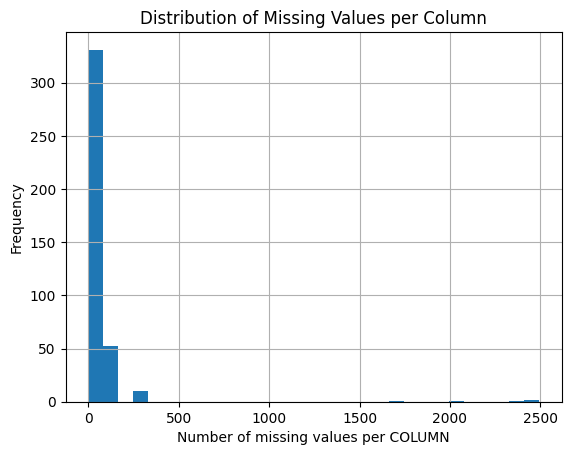

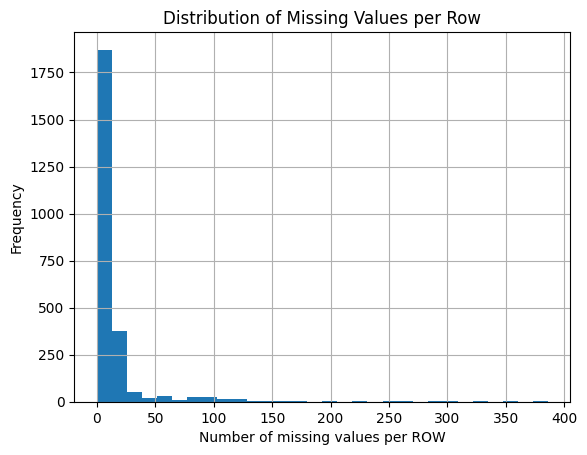

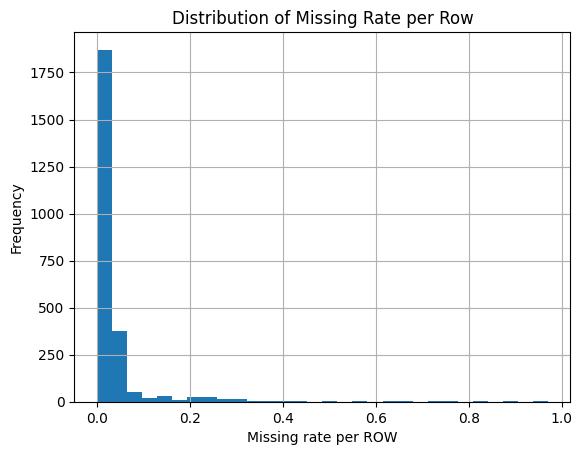

In [69]:
# 1) 列の切り出し（この範囲指定は列順に依存。想定どおりの列が入っているか要確認）
cov1 = df_main.loc[:, "SEX_CD":"INCOM_SA"].copy()
cov2 = df_main.loc[:, "SEN_01_MA":"SYM_34_MA"].copy()
cov3 = df_main.loc[:, "CV_01_0201":"DP_00_0229"].copy()
cov4 = df_main.loc[:, "PS_CAT_01":"PI_CAT_56"].copy()
cov5 = pd.concat([cov1, cov2, cov3, cov4], axis=1)

# 2) 文字ベースの欠損を正規化：空白だけのセルは NaN に
#   - 空白（半角/全角/タブ/改行）だけ → NaN
cov5 = cov5.replace(r'^\s*$', np.nan, regex=True)

#   - 文字列としての 'NaN'/'nan' だけ NaN に（実NaNはそのまま）
cov5 = cov5.replace({'NaN': np.nan, 'nan': np.nan})

# 3) 列ごとの欠損「数」と「率」
col_missing_count2 = cov5.isna().sum(axis=0)
col_missing_rate2  = cov5.isna().mean(axis=0)  # 0〜1

print("列ごとの欠損数:")
print( col_missing_count2.sort_values(ascending=False).head(20))

print("\n列ごとの欠損率:")
print((col_missing_rate2.sort_values(ascending=False).head(20)).round(3))

# 4) 行ごとの欠損「数」と「率」
row_missing_count2 = cov5.isna().sum(axis=1)
row_missing_rate2  = cov5.isna().mean(axis=1)  # 0〜1

# 5) 可視化
# 列ごとの欠損数ヒスト
plt.figure()
col_missing_count2.hist(bins=30)
plt.xlabel("Number of missing values per COLUMN")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Values per Column")
plt.show()

# 行ごとの欠損数ヒスト
plt.figure()
row_missing_count2.hist(bins=30)
plt.xlabel("Number of missing values per ROW")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Values per Row")
plt.show()

# 行ごとの欠損率ヒスト
plt.figure()
row_missing_rate2.hist(bins=30)
plt.xlabel("Missing rate per ROW")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Rate per Row")
plt.show()

列ごとの欠損数:
PS_CAT_02    288
PI_CAT_01    288
PS_CAT_03    288
PS_CAT_04    288
PI_CAT_03    288
PI_CAT_05    288
PS_CAT_05    288
PS_CAT_01    288
PI_CAT_04    288
PI_CAT_02    288
PS_CAT_36    153
PS_CAT_34    153
PI_CAT_34    153
PI_CAT_35    153
PS_CAT_35    153
PI_CAT_36    153
PI_CAT_14    148
PI_CAT_18    148
PS_CAT_18    148
PI_CAT_17    148
dtype: int64

列ごとの欠損率:
PS_CAT_02    0.115
PI_CAT_01    0.115
PS_CAT_03    0.115
PS_CAT_04    0.115
PI_CAT_03    0.115
PI_CAT_05    0.115
PS_CAT_05    0.115
PS_CAT_01    0.115
PI_CAT_04    0.115
PI_CAT_02    0.115
PS_CAT_36    0.061
PS_CAT_34    0.061
PI_CAT_34    0.061
PI_CAT_35    0.061
PS_CAT_35    0.061
PI_CAT_36    0.061
PI_CAT_14    0.059
PI_CAT_18    0.059
PS_CAT_18    0.059
PI_CAT_17    0.059
dtype: float64


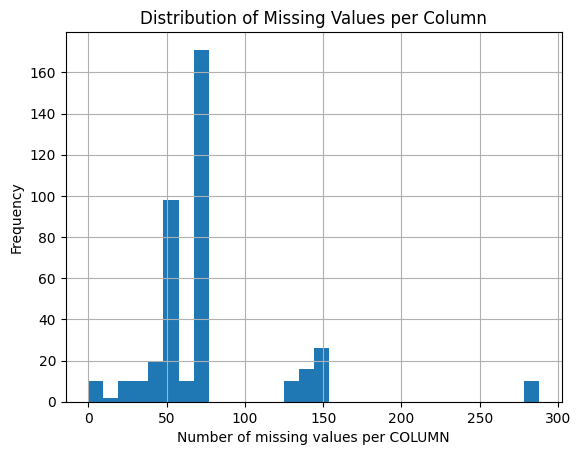

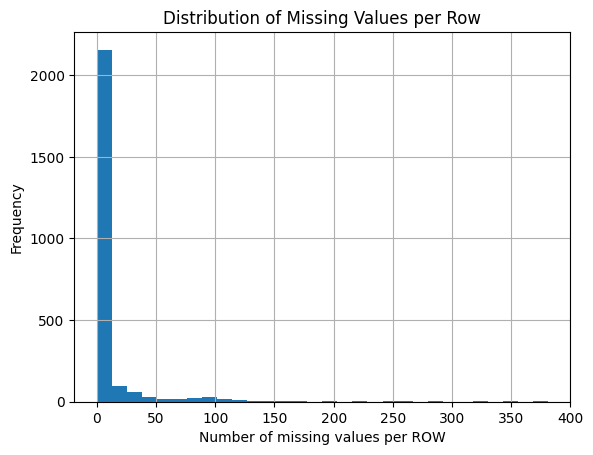

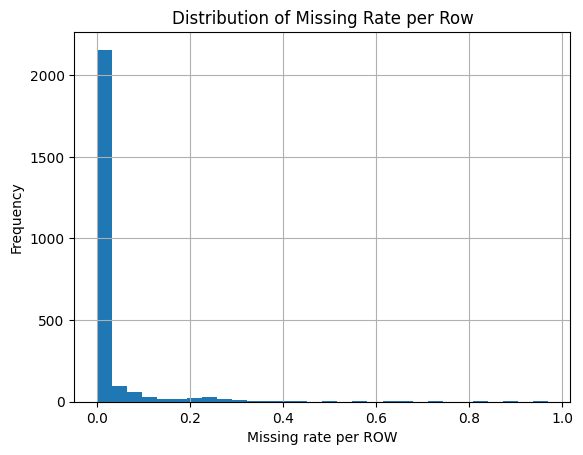

In [70]:
#欠損率の高いchild_ageをdropする
drop_cols = ["CHILD_AGE_1","CHILD_AGE_2","CHILD_AGE_3","CHILD_AGE_4","CHILD_AGE_5"]
cov6 = cov5.drop(columns=drop_cols)

# 3) 列ごとの欠損「数」と「率」
col_missing_count2 = cov6.isna().sum(axis=0)
col_missing_rate2  = cov6.isna().mean(axis=0)  # 0〜1

print("列ごとの欠損数:")
print( col_missing_count2.sort_values(ascending=False).head(20))

print("\n列ごとの欠損率:")
print((col_missing_rate2.sort_values(ascending=False).head(20)).round(3))

# 4) 行ごとの欠損「数」と「率」
row_missing_count2 = cov6.isna().sum(axis=1)
row_missing_rate2  = cov6.isna().mean(axis=1)  # 0〜1

# 5) 可視化
# 列ごとの欠損数ヒスト
plt.figure()
col_missing_count2.hist(bins=30)
plt.xlabel("Number of missing values per COLUMN")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Values per Column")
plt.show()

# 行ごとの欠損数ヒスト
plt.figure()
row_missing_count2.hist(bins=30)
plt.xlabel("Number of missing values per ROW")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Values per Row")
plt.show()

# 行ごとの欠損率ヒスト
plt.figure()
row_missing_rate2.hist(bins=30)
plt.xlabel("Missing rate per ROW")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Rate per Row")
plt.show()

処置変数の分布確認

In [71]:
tv_watch_selected["視聴番組フラグ"].value_counts(normalize=True)

,proportion
視聴番組フラグ,
1.0,0.7376
0.0,0.2624


overlapの仮定を満たすか確認

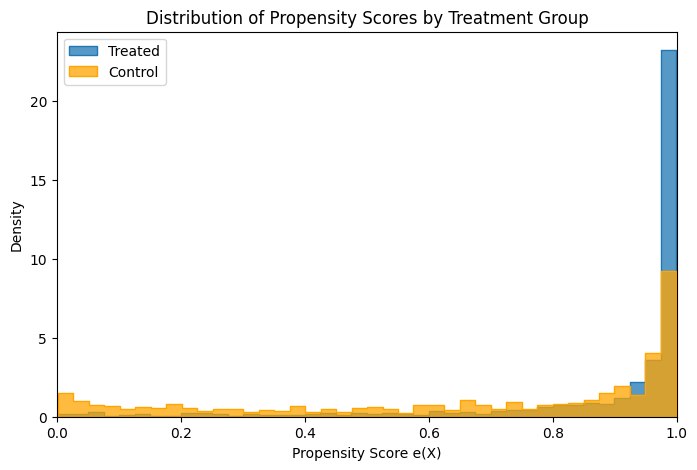

Overlap OK率: 0.402


In [72]:
# === 1. データの準備 ===
D = tv_watch_selected["視聴番組フラグ"].values   # 処置変数
X = cov6.values                                  # 共変量

# === 2. 傾向スコアの推定 ===

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  e_hat は zeros ではなく empty で初期化（未予測値に0を入れない）
e_hat = np.empty(len(D), dtype=float)

for tr, va in skf.split(X, D):
    ps_model = LGBMClassifier(
        n_estimators=500, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )
    ps_model.fit(X[tr], D[tr])
    e_hat[va] = ps_model.predict_proba(X[va])[:, 1]  # 処置を受ける確率 P(D=1|X)

#  ループの外で1回だけ軽くクリップ（ゼロ割れ防止）
e_hat = np.clip(e_hat, 1e-3, 1-1e-3)

# === 3. 分布の可視化 ===
plt.figure(figsize=(8,5))
sns.histplot(e_hat[D==1], bins=40, stat="density", element="step", label="Treated")
sns.histplot(e_hat[D==0], bins=40, stat="density", element="step", label="Control", color="orange")
plt.xlim(0,1)
plt.xlabel("Propensity Score e(X)")
plt.ylabel("Density")
plt.title("Distribution of Propensity Scores by Treatment Group")
plt.legend()
plt.show()


# === 4. overlap診断の数値化 ===
# e(X) が [0.05, 0.95] に入っている割合を計算
overlap_ok = ((e_hat > 0.05) & (e_hat < 0.95)).mean()
print(f"Overlap OK率: {overlap_ok:.3f}")

有効サンプルサイズ (ESS)

$$
ESS = \frac{\left( \sum_{i=1}^{n} w_i \right)^2}{\sum_{i=1}^{n} w_i^2}
$$

IPW の重み

$$
w_i = \frac{D_i}{\hat{e}_i} + \frac{1 - D_i}{1 - \hat{e}_i}, \quad \hat{e}_i = P(D=1 \mid X_i)
$$

In [73]:
# ESS/nを測る式　重み付き推定（とくにIPW）のとき、実質的に何人分の情報が効いているかを数で表した指標。
# 極端な重みがあると、少数の観測が結果を支配して分散が膨らむ → ESS が小さくなる

w = D/e_hat + (1-D)/(1-e_hat)
ESS = (w.sum()**2) / (w**2).sum()
ESS_ratio = ESS / len(D)
print(f"ESS={ESS:.1f}, ESS/n={ESS_ratio:.3f}")

ESS=91.3, ESS/n=0.037


In [74]:
# ========= 5. 診断関数（ESSや重みの尾） =========
import numpy as np

def diagnose_ps(e_hat, D, alpha=0.05, name="model"):
    e = np.clip(e_hat, 1e-6, 1-1e-6)
    ok = ((e > alpha) & (e < 1-alpha)).mean()
    w  = D/e + (1-D)/(1-e)
    ESS = (w.sum()**2) / (w**2).sum()
    # 群別ESS
    w1, w0 = D/e, (1-D)/(1-e)
    ESS1 = (w1.sum()**2) / (w1**2).sum()
    ESS0 = (w0.sum()**2) / (w0**2).sum()
    # 尾の重さ
    p99 = np.percentile(w, 99)
    tail_ratio = w.max() / np.median(w)
    print(f"\n[{name}] Overlap {alpha:.2f}-{1-alpha:.2f}: {ok:.3f} | ESS/n={ESS/len(D):.3f} (ESS={ESS:.1f})")
    print(f"       group ESS/n: D=1 -> {ESS1/len(D):.3f},  D=0 -> {ESS0/len(D):.3f}")
    print(f"       tail: p99={p99:.2f},  max/median={tail_ratio:.1f}")
    return {"ok": ok, "ess_ratio": ESS/len(D), "ESS": ESS}

# 現状モデル（素のOOF LGBM）の診断
diag_base = diagnose_ps(e_hat, D, name="LGBM (base)")



[LGBM (base)] Overlap 0.05-0.95: 0.402 | ESS/n=0.037 (ESS=91.3)
       group ESS/n: D=1 -> 0.007,  D=0 -> 0.032
       tail: p99=743.60,  max/median=952.2



[LGBM + Isotonic] Overlap 0.05-0.95: 0.956 | ESS/n=0.524 (ESS=1310.8)
       group ESS/n: D=1 -> 0.671,  D=0 -> 0.160
       tail: p99=11.00,  max/median=14.8


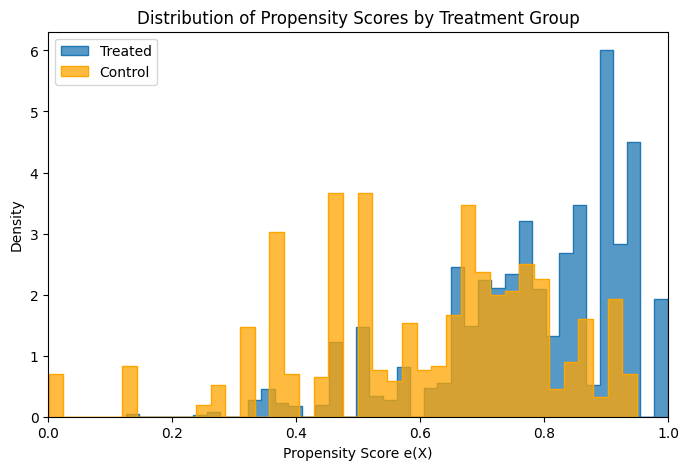

In [75]:
# ========= 6. LGBM + 等確率校正（isotonic）をOOFで作る =========
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
e_hat_iso = np.empty(len(D), dtype=float)

for tr, va in skf.split(X, D):
    base = LGBMClassifier(
        n_estimators=500, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    base.fit(X[tr], D[tr])
    cal = CalibratedClassifierCV(base, method="isotonic", cv="prefit")
    cal.fit(X[va], D[va])                       # 検証foldで確率を校正
    e_hat_iso[va] = cal.predict_proba(X[va])[:, 1]

e_hat_iso = np.clip(e_hat_iso, 1e-3, 1-1e-3)
diag_iso = diagnose_ps(e_hat_iso, D, name="LGBM + Isotonic")

# === 3. 分布の可視化 ===
plt.figure(figsize=(8,5))
sns.histplot(e_hat_iso[D==1], bins=40, stat="density", element="step", label="Treated")
sns.histplot(e_hat_iso[D==0], bins=40, stat="density", element="step", label="Control", color="orange")
plt.xlim(0,1)
plt.xlabel("Propensity Score e(X)")
plt.ylabel("Density")
plt.title("Distribution of Propensity Scores by Treatment Group")
plt.legend()
plt.show()


# DMLの実行

In [76]:
from sklearn.impute import SimpleImputer
Y_col = "PI_02_B00001262"

# 1) 配列を用意（Xは数値化しておく）
X_df = cov6.copy().apply(pd.to_numeric, errors="coerce")   # 非数値は NaN に　applyは各列に　pd.to_numericは数値に変換する関数　coereceは数値以外のものをNanに
Y_sr = pd.to_numeric(tv_watch_selected[Y_col], errors="coerce")
T_sr = pd.to_numeric(tv_watch_selected["視聴番組フラグ"], errors="coerce")

# 2) 欠損の所在をざっと確認
print("NaN counts ->  X:", int(X_df.isna().to_numpy().sum()), #isnaは各セルがNanかどうかをtrue/faleで返す to_numpyはnumpyに変換
      "/ Y:", int(Y_sr.isna().sum()),
      "/ T:", int(T_sr.isna().sum()))


# 3) まず Y/T の欠損は行削除（識別に直接影響するため）
mask_y_t = (~Y_sr.isna()) & (~T_sr.isna()) #~は否定演算　&はかつ　つまりどちらもNanでないものをTにしてそれ以外はF
X_df2 = X_df.loc[mask_y_t]                 #loc[]で行選択、Tの行だけを取得、Fは取得しない
Y = Y_sr.loc[mask_y_t].to_numpy()
T = T_sr.loc[mask_y_t].to_numpy()

# 4) X の欠損は単純補完（最頻値）
imputer = SimpleImputer(strategy="most_frequent") #Nanを最頻値で埋めるためのモデル
X_imp = imputer.fit_transform(X_df2)  # .fitで最頻値を学習、transformでそれをNanに埋める .fit_transform()はそれを一つに繋いだ

# 5) 最終チェック（全てNaNなしになるはず）
assert np.isfinite(X_imp).all()   #isfiniteは有限値（NaNでも±infでもない値）かどうかを要素ごとに判定
assert np.isfinite(Y).all()       #allは配列の中身がすべて True なら True を返す。   assertは条件が False ならエラーを出して処理を止める
assert np.isfinite(T).all()
print("After cleaning -> shapes:", X_imp.shape, Y.shape, T.shape)

NaN counts ->  X: 30340 / Y: 122 / T: 0
After cleaning -> shapes: (2378, 393) (2378,) (2378,)


In [79]:
# 1) PSモデル（LGBM + Isotonic）。位置引数で推定器を渡す（互換性のため）
model_t = CalibratedClassifierCV(
    LGBMClassifier(
        n_estimators=500, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        verbosity=-1,
    ),
    method="isotonic",
    cv=3
)

# 2) アウトカム回帰（LGBM）
model_y = LGBMRegressor(
    n_estimators=600, learning_rate=0.03,
    num_leaves=31, subsample=0.8, colsample_bytree=0.8,
    min_child_samples=50, reg_lambda=1.0, random_state=42,
    verbosity=-1,
)

# 3) DML（5分割でクロスフィット）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dml = LinearDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,   # Tが0/1
    cv=cv,
    random_state=42
)

# 4) 学習＆推定
dml.fit(Y=Y, T=T, X=X_imp)
ate = dml.ate(X_imp)
lb, ub = dml.ate_interval(X_imp, alpha=0.05)
print(f"ATE (econml LinearDML) = {ate:.4f}   95% CI = [{lb:.4f}, {ub:.4f}]")

# サマリー
try:
    intercept = dml.intercept_
    stderr = dml.intercept_stderr_
    zstat = dml.intercept_zstat_
    pvalue = dml.intercept_pvalue_
    ci = dml.intercept_interval(alpha=0.05)

    print("\nCATE Intercept Results")
    print("="*60)
    print(f"point_estimate = {intercept:.3f}, stderr = {stderr:.3f}, "
          f"zstat = {zstat:.3f}, pvalue = {pvalue:.3f}, "
          f"ci_lower = {ci[0]:.3f}, ci_upper = {ci[1]:.3f}")
except Exception:
    pass


ATE (econml LinearDML) = -0.0618   95% CI = [-0.1879, 0.0643]


## 購買数の場合

In [80]:
# --- アウトカム差し替え版（前回の変数は壊さない） ---

# 1) 列名チェック
Y_col2 = "PS_02_B00001262"


# 2) Y/T の作り直し（_2 で別名）
Y_sr2 = pd.to_numeric(tv_watch_selected[Y_col2], errors="coerce")
mask_y_t2 = (~Y_sr2.isna()) & (~T_sr.isna())   # T_sr は前回のを流用（上書きしない）

# 3) 行をそろえて取り直し
X_df2_2 = X_df.loc[mask_y_t2]                  # X_df は前回のを流用
Y2 = Y_sr2.loc[mask_y_t2].to_numpy()
T2 = T_sr.loc[mask_y_t2].to_numpy()

# 4) X の補完（別 imputer を使って前回を保持）
imputer2 = SimpleImputer(strategy="most_frequent")
X_imp2 = imputer2.fit_transform(X_df2_2)

# 5) モデルを別インスタンスで（前回の dml を保持）
model_t2 = CalibratedClassifierCV(
    LGBMClassifier(
        n_estimators=500, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        verbosity=-1,
    ),
    method="isotonic", cv=3
)
model_y2 = LGBMRegressor(
    n_estimators=600, learning_rate=0.03,
    num_leaves=31, subsample=0.8, colsample_bytree=0.8,
    min_child_samples=50, reg_lambda=1.0, random_state=42,
    verbosity=-1,
)
cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dml2 = LinearDML(
    model_y=model_y2, model_t=model_t2,
    discrete_treatment=True, cv=cv2, random_state=42
)

# 6) 学習 & 推定（前回の dml は触らない）
dml2.fit(Y=Y2, T=T2, X=X_imp2)
ate2 = dml2.ate(X_imp2)
lb2, ub2 = dml2.ate_interval(X_imp2, alpha=0.05)
print(f"[PS_02_B00001262] ATE={ate2:.4f}  95% CI=[{lb2:.4f}, {ub2:.4f}]  n={X_imp2.shape[0]}")

# サマリー
try:
    inter = dml2.intercept_
    se    = dml2.intercept_stderr_
    z     = dml2.intercept_zstat_
    pv    = dml2.intercept_pvalue_
    ci_lo, ci_up = dml2.intercept_interval(alpha=0.05)

    print("\nCATE Intercept Results")
    print("="*60)
    print(f"point_estimate={inter:.3f}  stderr={se:.3f}  zstat={z:.3f}  "
          f"pvalue={pv:.3f}  ci_lower={ci_lo:.3f}  ci_upper={ci_up:.3f}")
except Exception:
    pass


[PS_02_B00001262] ATE=-0.0095  95% CI=[-0.1190, 0.1000]  n=2378
